# TDCommon Antibody-antigen Affinity Prediction Task

In this notebook we'll build models to predict this TDCommons dataset: https://tdcommons.ai/multi_pred_tasks/antibodyaff/

**Definition:** Antibodies recognize pathogen antigens and destroy them. The activity is measured by their binding affinities. This task is to predict the affinity from the amino acid sequences of both antigen and antibodies.

**Impact:** Compared to small-molecule drugs, antibodies have numerous ideal properties such as minimal adverse effect and also can bind to many "undruggable" targets due to different biochemical mechanisms. Besides, a reliable affinity predictor can help accelerate the antibody development processes by reducing the amount of wet-lab experiments.

**Generalization:** The models are expected to extrapolate to unseen classes of antigen and antibody pairs.

**Product:** Antibody, immunotherapy.

**Pipeline:** Activity.

## TODO
Instead of joining the antibody and antigen sequence in a single embedding try to embed both separately and pass them in as two input vectors.

In [1]:
import torch

In [2]:
torch.cuda.is_available()

True

## ESM2 Embedder using HuggingFace

[ESM2 protein language model](https://github.com/facebookresearch/esm) to embed protein sequences into an embedding space. We need the embedding space because the computer doesn't know how to handle amino acid sequences. Instead, the ESM2 embedder converts the amino acid sequences into a vector of 320 numbers that the computer can understand. This embedding vector inherently embeds features about the amino acid sequence and the 3D protein structure.


## Load HuggingFace model

In [3]:
from transformers import AutoTokenizer, EsmModel

In [4]:
model_name = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = EsmModel.from_pretrained(model_name)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Put tensor(s) on the desired hardware device. If CUDA (GPU) is available, then use that. If not, then use CPU.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


## Multimers

If the protein consists of multiple chains (multimers), then connect them as one long sequence string by inserting a chain of "G" in between.

In [6]:
chain_A = "MRLIPLHNVDQVAKWSARYIVDRINQFQPTEARPFVLGLPTGGTPLKTYEALIELYKAGEVSFKHVVTFNMDEYVGLPKEHPESYHSFMYKNFFDHVDIQEKNINILNGNTEDHDAECQRYEEKIKSYGKIHLFMGGVGVDGHIAFNEPASSLSSRTRIKTLTEDTLIANSRFFDNDVNKVPKYALTIGVGTLLDAEEVMILVTGYNKAQALQAAVEGSINHLWTVTALQMHRRAIIVCDEPATQELKVKTVKYFTELEASAIRSVK"
chain_B = "HPESYHSFMYKNFFDHVDIQEKRTTDINRT"

linker_sequence = "G" * 25  # Put G linker in between chains (hide it later)

multimer_sequence = chain_A + linker_sequence + chain_B

Tokenize the input sequence string

In [7]:
tokenized_multimer = tokenizer([multimer_sequence], return_tensors="pt", add_special_tokens=False)

Renumber the positions of the second chain so that the model knows that the second chain is not really connected. 

In [8]:
with torch.no_grad():
    position_ids = torch.arange(len(multimer_sequence), dtype=torch.long)
    position_ids[len(chain_A) + len(linker_sequence):] += 512

In [9]:
tokenized_multimer['position_ids'] = position_ids.unsqueeze(0)

tokenized_multimer = {key: tensor.to(device) for key, tensor in tokenized_multimer.items()}

In [10]:
with torch.no_grad():
    output = model(**tokenized_multimer)

In [11]:
output.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

The embeddings are the last hidden state of the model.

In [12]:
output["last_hidden_state"].shape

torch.Size([1, 322, 320])

In [13]:
position_ids.shape

torch.Size([322])

## Create embedding function

Preprocess data to get the ESM2 embedding space from the raw sequence strings

In [14]:
import numpy as np
from tqdm import tqdm

In [15]:
def embed_antibody(sequence_strs: str):
    """Embed antibody using ESM2
    
    Args:
        sequence_strs(str): List of the heavy and light chain sequence strings
                        It's really a list that has been converted to string because Pandas can't handle arrays

    Returns:
        PyTorch embedding vector. 1 x length of sequence x 320 embedding dimensions
    """

    embed_sequences = []
    
    for sequence_str in sequence_strs:
        sequences = sequence_str.split("'")[1:3]
        
        linker_sequence = "G" * 25  # Put G linker in between chains (hide it later)
        multimer_sequence = sequences[0] + linker_sequence + sequences[1]
    
        tokenized_multimer = tokenizer([multimer_sequence], return_tensors="pt", add_special_tokens=False)
    
        with torch.no_grad():
            position_ids = torch.arange(len(multimer_sequence), dtype=torch.long)
            position_ids[len(sequences[0]) + len(linker_sequence):] += 512
    
        
        tokenized_multimer['position_ids'] = position_ids.unsqueeze(0)
    
        tokenized_multimer = {key: tensor.to(device) for key, tensor in tokenized_multimer.items()}
        with torch.no_grad():
            output = model(**tokenized_multimer)
    
        embedding = output["last_hidden_state"]
        mean_embedding = torch.mean(embedding, axis=1)
        
        embed_sequences.append(mean_embedding.to("cpu").numpy().T)

    return np.array(embed_sequences)
    

## TD Commons - SAbDab Dataset

The dataset is: https://tdcommons.ai/multi_pred_tasks/antibodyaff/

From the dataset description:

**Dataset Description:** Antibody-antigen affinity measures the efficacy of the antibody to the antigen. Processed from SAbDab dataset, where we only use protein/peptide antigens for sequence compatbility.

**Task Description:** Regression. Given the amino acid sequence of antibody and antigen, predict their binding affinity.

**Dataset Statistics:** 493 pairs, 431 antibodies and 401 antigens.

> Note:
>
> In the antibody column, each antibody is organized from left to right as heavy chain to light chain. Also, we highly suggest you take the log affinity when making prediction.

**Dataset Split:** Random Split

```
from tdc.multi_pred import AntibodyAff
data = AntibodyAff(name = 'Protein_SAbDab')
split = data.get_split()
```

**References:**

[1] Dunbar, James, et al. “SAbDab: the structural antibody database.” Nucleic acids research 42.D1 (2014): D1140-D1146.

**Dataset License:** CC BY 3.0.

In [16]:
from tdc.multi_pred import AntibodyAff
data = AntibodyAff(name = "Protein_SAbDab")
split = data.get_split()

Found local copy...
Loading...
Done!


In [17]:
split["train"].head(5)

,Antibody_ID,Antibody,Antigen_ID,Antigen,Y
0,4i2x,['EVKLQQSGPELVKPGASVKISCKASGYSFTSYYIHWVKQRPGQG...,signal-regulatory protein gamma,EEELQMIQPEKLLLVTVGKTATLHCTVTSLLPVGPVLWFRGVGPGR...,1.200000e-06
1,5vyf,['EVQLVESGGGLVQPGGSLRLSCAASGFTFSSYAMSWVRQAPGKG...,chimera of major allergen i polypeptide chain ...,VKMAETCPIFYDVFFAVANGNELLLDLSLTKVAATEPERTAMKKIQ...,1.870000e-10
2,3eob,['EVQLVESGGGLVQPGGSLRLSCAASGYSFTGHWMNWVRQAPGKG...,integrin alpha-l,GNVDLVFLFDGSMSLQPDEFQKILDFMKDVMKKLSNTSYQFAAVQF...,2.200000e-09
3,2r56,['QVSLRESGGGLVQPGRSLRLSCTASGFTFRHHGMTWVRQAPGKG...,beta-lactoglobulin,LIVTQTMKGLDIQKVAGTWYSLAMAASDISLLDAQSAPLRVYVEEL...,1.300000e-09
4,4yhz,['EVQLVETGGGVVQPGRSLRLSCTASGFTFRDYWMSWVRQAPGKG...,h3k4me3 peptide,ARTKQTARKSTG,1.100000e-08


In [18]:
split["test"].head(5)

,Antibody_ID,Antibody,Antigen_ID,Antigen,Y
0,1tzh,['EVQLVESGGGLVQPGGSLRLSCAASGFDIYDDDIHWVRQAPGKG...,vascular endothelial growth factor a,GQNHHEVVKFMDVYQRSYCHPIETLVDIFQEYPDEIEYIFKPSCVP...,1.800000e-09
1,5xmh,['MQVQLVQSGAEVKKPGSSVKVSCKASGGTFSSYPISWVRQAPGQ...,immunoglobulin gamma-1 heavy chain,GPSVFLFPPKPKDTLMISRTPEVTCVVVDVSHEDPEVKFNWYVDGV...,1.600000e-04
2,2ny3,['EVQLVESGAEVKKPGSSVKVSCKASGDTFIRYSFTWVRQAPGQG...,envelope glycoprotein gp120,EVVLVNVTENFNMWKNDMVEQMHEDIISLWDQSLKPCVKLTPLCVG...,8.150000e-07
3,1nca,['QIQLVQSGPELKKPGETVKISCKASGYTFTNYGMNWVKQAPGKG...,influenza a subtype n9 neuraminidase,IRDFNNLTKGLCTINSWHIYGKDNAVRIGEDSDVLVTREPYVSCDP...,8.300000e-09
4,3idx,['QVQLVESGGGVVQPGRSLRLSCAASGFTFRNYAMHWVRQAPGKG...,hiv-1 hxbc2 gp120 core,EVVLVNVTENFNWCKNDMVEQMHEDICSLWDQSLKPCVKLTPLCVG...,4.040000e-09


In [19]:
split["valid"].head(5)

,Antibody_ID,Antibody,Antigen_ID,Antigen,Y
0,4ffz,['QVQLLQPGAELVKPGASMKLSCKASGYTFTNWWMHWVRLRPGRG...,envelope protein e,MASMTLKGMSYVMCTGSFKLEKEVAETQHGTVLVQVKYEGTDAPCK...,4.160000e-07
1,2fx9,['QVQLVQSGAEVKRPGSSVTVSCKASGGSFSTYALSWVRQAPGRG...,fragment of hiv glycoprotein gp41,NWFCITRWLWKKKK,1.700000e-08
2,6ddm,['EIQLQQSGPELVKPGASVKVSCKASGYAFTSQNIYWVKQSHGKS...,mhc class i polypeptide-related sequence a,TVPPMVNVTRSEASEGNITVTCRASSFYPRNIILTWRQDGVSLSHD...,4.200000e-10
3,1n64,['QIQLVQSGPELKKPGETVKISCKASGYTFTDFSMHWVNQAPGKG...,genome polyprotein capsid protein c,PGGGQIVGGVYLLPRR,1.300000e-09
4,4iof,['MKKNIAFLLASMFVFSIATNAYAEISEVQLVESGGGLVQPGGSL...,insulin-degrading enzyme,MHHHHHHAAGIPMNNPAIKRIGNHITKSPEDKREYRGLELANGIKV...,4.000000e-09


## Generate the X and y datasets

**TODO* Add the antigen embedding as a second input

In [20]:
X_train = embed_antibody(split["train"]["Antibody"])
X_valid = embed_antibody(split["valid"]["Antibody"])
X_test  = embed_antibody(split["test"]["Antibody"])

In [21]:
X_train.shape

(345, 320, 1)

In [22]:
X_test.shape

(99, 320, 1)

In [23]:
# Recommend to take the log transform on the affinity values to make them more linear
y_train = np.log(split["train"]["Y"].values)
y_valid = np.log(split["valid"]["Y"].values)
y_test =  np.log(split["test"]["Y"].values)

In [24]:
from torch import nn
import torch.backends
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl

from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from torchmetrics.regression import MeanSquaredError

In [25]:
pl.seed_everything(816)  # Random seed to ensure deterministic training

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True

Seed set to 816


In [26]:
class Lit_Affinity_Model(pl.LightningModule):
    """PyTorch Lightning Module

    Defines the PyTorch model. Defines the training, validation, and testing for the model.

    """

    def __init__(self, kwargs):
        super().__init__()

        # Training parameters
        self.learning_rate = kwargs["learning_rate"]
        self.train_batch_size = kwargs["train_batch_size"]
        self.val_batch_size = kwargs["validation_batch_size"]
        self.test_batch_size = kwargs["test_batch_size"]

        self.X_train = kwargs["X_train"]
        self.y_train = kwargs["y_train"]

        self.X_validation = kwargs["X_validation"]
        self.y_validation = kwargs["y_validation"]

        self.X_test = kwargs["X_test"]
        self.y_test = kwargs["y_test"]

        # Model layers
        self.layer1 = nn.Linear(kwargs["input_dim"], 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer_out = nn.Linear(256, 1)

        # Metrics
        self.train_mse = MeanSquaredError()
        self.val_mse = MeanSquaredError()
        self.test_mse = MeanSquaredError()

        self.normalize_input = kwargs["Normalize input"]

    def forward(self, x):
        """Define forward pass for model

        Args:
            x: Input to model
        """

        # Define our model

        x = x.view(x.size(0), -1)  # Reshape input vector

        # Normalize the input embedding vector to mean 0 and standard deviation 1
        if self.normalize_input:
            x = nn.functional.normalize(x)

        x = self.layer1(x)
        x = nn.ReLU()(x)

        x = self.layer2(x)
        x = nn.ReLU()(x)

        # Add dropout layer with 0.2 probability of dropout
        x = nn.Dropout(p=0.2)(x)

        x = self.layer_out(x)

        return x

    def configure_optimizers(self):
        """Configure the SGD optimizer"""
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        """Defines what happens at each step in training

        batch:  A batch from the data loader
        batch_idx(int): The index of the batch
        """
        # training_step defines the train loop.
        input_vector, label = batch
        prediction = self.forward(input_vector)

        loss = nn.MSELoss()(prediction, label)

        self.train_mse.update(prediction, label)

        return loss

    def validation_step(self, batch, batch_idx):
        """Defines what happens at each step in validation

        batch:  A batch from the data loader
        batch_idx(int): The index of the batch
        """
        # training_step defines the train loop.
        input_vector, label = batch
        prediction = self.forward(input_vector)
        loss = nn.MSELoss()(prediction, label)

        self.val_mse.update(prediction, label)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_mse", loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        """Defines what happens at each step in testing

        batch:  A batch from the data loader
        batch_idx(int): The index of the batch
        """
        input_vector, label = batch
        prediction = self.forward(input_vector)
        loss = nn.MSELoss()(prediction, label)

        self.test_mse.update(prediction, label)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_mse", loss, prog_bar=True)

    def train_dataloader(self):
        """Defines the PyTorch data loader for the training data"""
        train = TensorDataset(
            torch.Tensor(self.X_train),
            torch.Tensor(np.expand_dims(self.y_train, axis=1)),
        )
        return DataLoader(train, batch_size=self.train_batch_size, shuffle=True)

    def val_dataloader(self):
        """Defines the PyTorch data loader for the validation data"""
        validate = TensorDataset(
            torch.Tensor(self.X_validation),
            torch.Tensor(np.expand_dims(self.y_validation, axis=1)),
        )
        return DataLoader(validate, batch_size=self.val_batch_size, shuffle=False)

    def test_dataloader(self):
        """Defines the PyTorch data loader for the testing data"""
        test = TensorDataset(
            torch.Tensor(self.X_test), torch.Tensor(np.expand_dims(self.y_test, axis=1))
        )
        return DataLoader(test, batch_size=self.test_batch_size, shuffle=False)

In [27]:
model_parameters = {
    "input_dim": X_train.shape[1],  # vector of 2560 elements
    "learning_rate": 1e-4,
    "X_train": X_train,
    "y_train": y_train,
    "X_validation": X_valid,
    "y_validation": y_valid,
    "X_test": X_test,
    "y_test": y_test,
    "train_batch_size": 32,
    "validation_batch_size": 16,
    "test_batch_size": 16,
    "Normalize input": True,
}

affinity_model = Lit_Affinity_Model(model_parameters)

In [28]:
progress_bar = TQDMProgressBar(refresh_rate=20)

In [29]:
early_stopping = EarlyStopping(
    monitor="val_mse",
    min_delta=0.001,
    patience=20,
)

In [30]:
model_checkpoint = ModelCheckpoint(monitor="val_mse")

In [31]:
# Initialize a trainer
trainer = pl.Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,
    max_epochs=1000,
    callbacks=[progress_bar, early_stopping, model_checkpoint],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [32]:
# Train the model ⚡
trainer.fit(affinity_model)

You are using a CUDA device ('NVIDIA RTX 2000 Ada Generation Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | layer1    | Linear           | 164 K 
1 | layer2    | Linear           | 131 K 
2 | layer_out | Linear           | 257   
3 | train_mse | MeanSquaredError | 0     
4 | val_mse   | MeanSquaredError | 0     
5 | test_mse  | MeanSquaredError | 0     
-----------------------------------------------
295 K     Trainable params
0         Non-trainable params
295 K     Total params
1.184     Total estimated model params size (MB)


Sanity Checking: |                                                                        | 0/? [00:00<?, ?it/…

Training: |                                                                               | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

In [33]:
trainer.test()

Restoring states from the checkpoint path at /home/tbreina/antibody-affinity/lightning_logs/version_12/checkpoints/epoch=28-step=319.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/tbreina/antibody-affinity/lightning_logs/version_12/checkpoints/epoch=28-step=319.ckpt


Testing: |                                                                                | 0/? [00:00<?, ?it/…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mse            11.318392753601074
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_mse': 11.318392753601074}]

In [34]:
affinity_model = Lit_Affinity_Model.load_from_checkpoint(
    model_checkpoint.best_model_path, kwargs=model_parameters
)

affinity_model.eval()  # This sets the model to inference-only

Lit_Affinity_Model(
  (layer1): Linear(in_features=320, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (layer_out): Linear(in_features=256, out_features=1, bias=True)
  (train_mse): MeanSquaredError()
  (val_mse): MeanSquaredError()
  (test_mse): MeanSquaredError()
)

In [35]:
def make_predictions(model, x_dataset: np.ndarray):
    """Use model to make binding predictions

    Args:
        model: The Pytorch model to use for inference
        x_dataset: A Numpy array of embedding vectors.

    """
    predictions_pytorch = []

    with torch.no_grad():

        for x in tqdm(x_dataset, desc="Making predictions on the dataset"):

            # Convert the NumPy vector to a PyTorch tensor
            tensor_x = torch.Tensor(np.expand_dims(x, 0)).to(device)

            prediction = model(tensor_x)

            predictions_pytorch.append(prediction.cpu().numpy())
            
    return np.squeeze(predictions_pytorch)

In [36]:
predictions_pytorch = make_predictions(affinity_model, X_test)

Making predictions on the dataset: 100%|██████████████████████████████████████| 99/99 [00:00<00:00, 1421.52it/s]


In [37]:
from seaborn import regplot
import pandas as pd

In [38]:
df_predictions = pd.DataFrame({"Measured Affinity": y_test, "Model Prediction": predictions_pytorch})

<Axes: xlabel='Measured Affinity', ylabel='Model Prediction'>

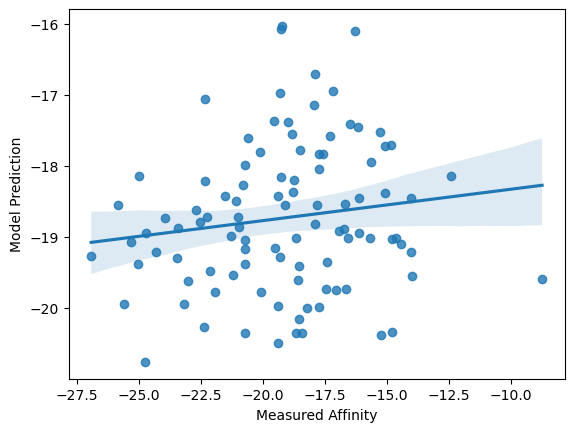

In [39]:
regplot(df_predictions, x="Measured Affinity", y="Model Prediction")